In [195]:
!pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.9 MB/s eta 0:00:00


In [426]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
from datetime import datetime
from datetime import timedelta


def dps_all_f(city,entity,start_date, end_date):

    query = """
    with details as (
    SELECT   smto.entity_id
            ,smto.country_code
            ,smto.city_id
            ,smto.city_name
            ,CONCAT(smto.city_name , "-", "post") city_name_var
            ,smto.created_date_local
            ,date_trunc(created_date_local, ISOWEEK) week
            ,date_trunc(created_date_local, MONTH) month
            ,smto.customer_account_id
            ,smto.customer_first_order_date
            ,smto.order_id
            ,smto.dps_delivery_fee_eur
            ,smto.delivery_fee_eur
            ,smto.delivery_fee_local
            ,dps_travel_time_fee_eur
            ,dps_standard_fee_eur
            ,vendor_funding_amount_local
            ,dps_last_non_zero_df_eur
            ,delivery_fee_vat_eur
            ,delivery_fee_vat_local
            ,smto.delivery_fee_option
            ,smto.priority_fee_eur
            ,smto.saver_discount_eur
            ,smto.gfv_eur
            ,smto.gfv_local
            ,smto.gmv_eur
            ,smto.gmv_local
            ,smto.profit_eur
            ,smto.profit_local
            ,smto.revenue_eur
            ,smto.revenue_local
            ,smto.mov_customer_fee_eur
            ,smto.service_fee_eur
            ,smto.dps_service_fee_eur
            ,smto.delivery_distance
            ,smto.delivery_costs_eur
            ,smto.delivery_costs_local
            ,smto.joker_vendor_fee_eur
            ,smto.is_sent
            ,smto.is_own_delivery
            ,smto.vertical_type
            ,(case when is_sent = TRUE then 1 else 0 end) completed_orders
            ,fully_loaded_gross_profit_eur
            ,smto.commission_eur
            ,smto.platform_order_code
            ,smto.has_new_customer_condition
            ,smto.new_customer_condition_type
    FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
    join
    (   SELECT  o.customer_account_id
        FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
        WHERE o.entity_id = \"""" + entity + """\"
            AND (o.customer_first_order_date is null
            OR date(o.customer_first_order_date) = '0001-01-01')
            AND o.city_name in (""" + city + """)
            group by 1
    ) tm on tm.customer_account_id = smto.customer_account_id
    WHERE smto.created_date_local BETWEEN \"""" + start_date + """\" AND \"""" + end_date + """\"
    AND city_name in (""" + city + """)
    AND is_own_delivery = TRUE
    AND is_sent = TRUE
    ),
    voucher_data as (
    SELECT  o.global_entity_id
            ,order_id
            ,o.customer_account_id
            ,vouchers[SAFE_OFFSET(0)].voucher_code voucher_code
            ,vouchers[SAFE_OFFSET(0)].amount_eur voucher_amount_eur
            ,(case when vouchers[SAFE_OFFSET(0)].voucher_code not in ('nyburgare', 'mumsigt','megagott','mums150') or
            vouchers[SAFE_OFFSET(0)].voucher_code not in ('mieletön', 'tajuton','uskomaton','arena','huikea') or 
            vouchers[SAFE_OFFSET(0)].voucher_code not like 'mieletön%' or 
            vouchers[SAFE_OFFSET(0)].voucher_code not like 'tajuton%' then vouchers[SAFE_OFFSET(0)].amount_eur else 0 end) voucher_amount_nc_eur
    FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` o
    where global_entity_id = \"""" + entity + """\"
    AND partition_date_local BETWEEN \"""" + start_date + """\" AND \"""" + end_date + """\"
    )
    select d.*
           ,vd.voucher_amount_eur
           ,voucher_amount_nc_eur
    from details d 
    left join voucher_data vd on vd.global_entity_id = d.entity_id and vd.order_id = d.platform_order_code
    """

    return query


def sessions(entity, city, start_date, end_date):

    query = """
    SELECT count(distinct perseus_session_key) total_sessions,
       count(distinct sessions.perseus_client_id) total_users,
       count(distinct case when has_transaction = True then sessions.perseus_client_id else null end) total_orders,
       count(distinct case when has_transaction = True then sessions.perseus_client_id else null end) / count(distinct perseus_session_key)   
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_perseus_sessions` 
    WHERE created_date BETWEEN \"""" + start_date + """\" AND \"""" + end_date + """\"
    AND entity_id = \"""" + entity + """\" 
    and dps_zone[SAFE_OFFSET(0)].city_name in (""" + city + """)
    """
    
    return query

def analyze_city_orders(df, period):
    
    df['entity_id_period'] = df['entity_id'] + '_' + period
        
    grouped_data_post = df.groupby('entity_id_period').agg({
        'platform_order_code': 'nunique',
        'customer_account_id': 'nunique',
        'gfv_eur': 'sum',
        'voucher_amount_eur': 'sum',
        'fully_loaded_gross_profit_eur': 'sum',
        'foregone_delivery_fee': 'sum'
    }).reset_index()

    grouped_data_post.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in grouped_data_post.columns]

    grouped_data_post = grouped_data_post.rename(columns={
        'platform_order_code': 'Orders',
        'customer_account_id': 'Acquistions',
        'voucher_amount_eur': 'Voucher_cost_eur',
        'gfv_eur':'GFV_eur',
        'fully_loaded_gross_profit_eur' : 'FLGP_eur',
        'foregone_delivery_fee': 'FDNC_cost_eur',
        })


    voucher_counts = df[(df['voucher_amount_eur'] > 0) & ((df['dps_delivery_fee_eur'] == 0) | (df['dps_delivery_fee_eur'].isna()))].groupby('entity_id_period')['platform_order_code'].nunique().reset_index()
    voucher_counts = voucher_counts.rename(columns={'platform_order_code': 'Stacked_orders'})

    grouped_data_post = grouped_data_post.merge(voucher_counts, on='entity_id_period', how='left').fillna(0)
    grouped_data_post[['GFV_eur','Voucher_cost_eur','FLGP_eur','FDNC_cost_eur']] = grouped_data_post[['GFV_eur','Voucher_cost_eur','FLGP_eur','FDNC_cost_eur']].astype(int)

    grouped_data_post['total_acquistion_cost'] = grouped_data_post['FDNC_cost_eur'] + grouped_data_post['Voucher_cost_eur']

    grouped_data_post = grouped_data_post[['entity_id_period','Orders','Stacked_orders','Acquistions','FDNC_cost_eur','Voucher_cost_eur','total_acquistion_cost','GFV_eur','FLGP_eur']]

    return grouped_data_post.round(0).set_index('entity_id_period').T

def cities_summary(pre_df, post_df):
    
    df2 = analyze_city_orders(pre_df, 'pre')
    df1 = analyze_city_orders(post_df, 'post')

    merged_df = pd.merge(df2, df1, left_index=True, right_index=True, how='outer')

    for col in merged_df.columns:
        if col.endswith('_post'):
            post = col
            pre = post.replace('_post', '_pre')  # Find the corresponding _pre column
            
            if pre in merged_df.columns:  # Ensure the _pre column exists
                # Calculate percentage change and store it in 'percentage_change'
                merged_df['percentage_change'] = round(
                    ((merged_df[post] - merged_df[pre]) / abs(merged_df[pre])) * 100, 0
                )
    
    return merged_df

def user_retention_wow(df):

    post_inter_df = df.copy()

    post_inter_df['first_order_date'] = post_inter_df.groupby('customer_account_id')['created_date_local'].transform('min')
    post_inter_df['week_diff'] = ((post_inter_df['created_date_local'] - post_inter_df['first_order_date']).dt.days // 7)

    total_users = post_inter_df['customer_account_id'].nunique()

    retention_df = post_inter_df.groupby('week_diff').agg(
        users_retained=('customer_account_id', 'nunique')
    ).reset_index()

    retention_df['wow_retention'] = round((retention_df['users_retained'] / retention_df['users_retained'][0]) * 100,2)
    
    return retention_df
  

# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 



In [427]:
## Treatment Cities ##

entity_id = 'OP_SE'

city = ('Uppsala','Vasteras','Orebro','Stockholm')
city_str = ",".join([f"'{c}'" for c in city])

## post time period ##
start_date_post = '2024-08-05'
end_date_post = '2024-09-29'
dps_post_treatment = client.query(dps_all_f(city_str, entity_id, start_date_post, end_date_post)).to_dataframe()

# Create a new column for the conditional forgone delivery fee
dps_post_treatment['foregone_delivery_fee'] = np.where(
    (dps_post_treatment['dps_delivery_fee_eur'] == 0) | (dps_post_treatment['dps_delivery_fee_eur'].isnull()), 
    dps_post_treatment['dps_standard_fee_eur'], 
    0
)
dps_post_treatment['foregone_delivery_fee_final'] = dps_post_treatment[(dps_post_treatment['has_new_customer_condition'] == False) & (dps_post_treatment['new_customer_condition_type'] != 'TOTAL')]['foregone_delivery_fee']

## pre time period ##

# Convert the strings to datetime objects
date_format = "%Y-%m-%d"
start_date = datetime.strptime(start_date_post, date_format)
end_date = datetime.strptime(end_date_post, date_format)

# Calculate the difference in days
days_difference = (end_date - start_date).days
days_difference

# Subtract the number of days from date1
new_date = start_date - timedelta(days=days_difference)
new_date_only = new_date.date()
new_date_string = new_date_only.strftime("%Y-%m-%d")

start_date_pre = new_date_string

tmp_dt = datetime.strptime(start_date_post, '%Y-%m-%d')
new_end_d = tmp_dt - timedelta(days=1)
new_end_d_s = new_end_d.strftime('%Y-%m-%d')
end_date_pre = new_end_d_s

dps_pre_treatment = client.query(dps_all_f(city_str, entity_id, start_date_pre, end_date_pre)).to_dataframe()
# Create a new column for the conditional forgone delivery fee
dps_pre_treatment['foregone_delivery_fee'] = np.where(
    (dps_pre_treatment['dps_delivery_fee_eur'] == 0) | (dps_pre_treatment['dps_delivery_fee_eur'].isnull()), 
    dps_pre_treatment['dps_standard_fee_eur'], 
    0
)
dps_pre_treatment['foregone_delivery_fee_final'] = dps_pre_treatment[(dps_pre_treatment['has_new_customer_condition'] == False) & (dps_pre_treatment['new_customer_condition_type'] != 'TOTAL')]['foregone_delivery_fee']

cities_summary(dps_pre_treatment, dps_post_treatment)

entity_id_period,OP_SE_pre,OP_SE_post,percentage_change
Acquistions,242561,250516,3.0
FDNC_cost_eur,771871,577808,-25.0
FLGP_eur,2941378,3350331,14.0
GFV_eur,19993766,22774314,14.0
Orders,780065,877985,13.0
Stacked_orders,19339,26629,38.0
Voucher_cost_eur,453686,589733,30.0
total_acquistion_cost,1225557,1167541,-5.0


In [428]:
## Control Cities ##

entity_id_control = 'OP_SE'

city = ('Umea','Malmo')
#city = ('Umea','Malmo')

city_str_control = ",".join([f"'{c}'" for c in city])

## post time period ##
start_date_post_control = '2024-08-05'
end_date_post_control = '2024-09-29'
post_control = client.query(dps_all_f(city_str_control, entity_id_control, start_date_post_control, end_date_post_control)).to_dataframe()
post_control['foregone_delivery_fee'] = np.where(
    (post_control['dps_delivery_fee_eur'] == 0) | (post_control['dps_delivery_fee_eur'].isnull()), 
    post_control['dps_standard_fee_eur'], 
    0
)
post_control['foregone_delivery_fee_final'] = post_control[(post_control['has_new_customer_condition'] == False) & (post_control['new_customer_condition_type'] != 'TOTAL')]['foregone_delivery_fee']


## pre time period ##

# Convert the strings to datetime objects
date_format = "%Y-%m-%d"
start_date = datetime.strptime(start_date_post_control, date_format)
end_date = datetime.strptime(end_date_post_control, date_format)

# Calculate the difference in days
days_difference = (end_date - start_date).days
days_difference

# Subtract the number of days from date1
new_date = start_date - timedelta(days=days_difference)
new_date_only = new_date.date()
new_date_string = new_date_only.strftime("%Y-%m-%d")

start_date_pre_control = new_date_string

tmp_dt_control = datetime.strptime(start_date_post_control, '%Y-%m-%d')
new_end_d_control = tmp_dt_control - timedelta(days=1)
new_end_d_s_control = new_end_d_control.strftime('%Y-%m-%d')
end_date_pre_control = new_end_d_s_control

pre_control = client.query(dps_all_f(city_str_control, entity_id_control, start_date_pre_control, end_date_pre_control)).to_dataframe()
pre_control['foregone_delivery_fee'] = np.where(
    (pre_control['dps_delivery_fee_eur'] == 0) | (pre_control['dps_delivery_fee_eur'].isnull()), 
    pre_control['dps_standard_fee_eur'], 
    0
)
pre_control['foregone_delivery_fee_final'] = pre_control[(pre_control['has_new_customer_condition'] == False) & (pre_control['new_customer_condition_type'] != 'TOTAL')]['foregone_delivery_fee']

cities_summary(pre_control, post_control)

entity_id_period,OP_SE_pre,OP_SE_post,percentage_change
Acquistions,47048,48775,4.0
FDNC_cost_eur,194319,109454,-44.0
FLGP_eur,705413,822013,17.0
GFV_eur,3742173,4082867,9.0
Orders,143347,154278,8.0
Stacked_orders,2687,3108,16.0
Voucher_cost_eur,63627,91216,43.0
total_acquistion_cost,257946,200670,-22.0


In [429]:
a = dps_post_treatment.groupby(['week']).agg({'customer_account_id':'nunique','platform_order_code':'nunique'}).reset_index()
b = dps_pre_treatment.groupby(['week']).agg({'customer_account_id':'nunique','platform_order_code':'nunique'}).reset_index()

c = post_control.groupby(['week']).agg({'customer_account_id':'nunique','platform_order_code':'nunique'}).reset_index()
d = pre_control.groupby(['week']).agg({'customer_account_id':'nunique','platform_order_code':'nunique'}).reset_index()

frames_t = [a,b]
combined_treatment  = pd.concat(frames_t)
combined_treatment['group'] = 'treatment'

frames_c = [c,d]
combined_control = pd.concat(frames_c)
combined_control['group'] = 'control'

frames_f = [combined_treatment,combined_control]
final_df = pd.concat(frames_f)

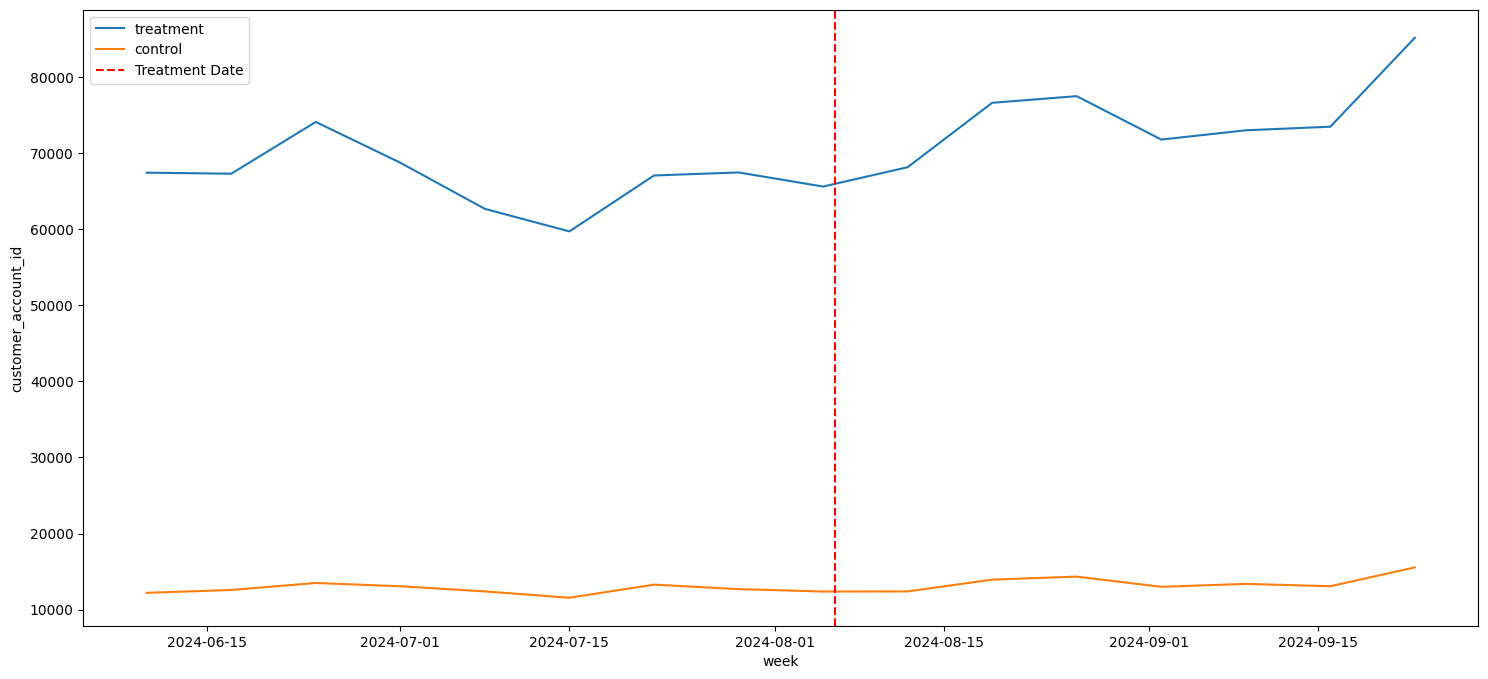

In [430]:
treatment_date = pd.to_datetime('2024-08-06')
plt.figure(figsize=(18, 8))
sns.lineplot(data=final_df, x='week', y='customer_account_id', hue='group')
plt.axvline(x=treatment_date, color='red', linestyle='--', label='Treatment Date')
plt.legend()
plt.show()

In [431]:
import pandas as pd
import plotly.express as px


# Example intervention date (replace this with your actual intervention date)
intervention_date = '2024-08-05'

# Ensure created_date_local is in datetime format
final_df['week'] = pd.to_datetime(final_df['week'], errors='coerce')

# Ensure platform_order_code is numeric
final_df['customer_account_id'] = pd.to_numeric(final_df['customer_account_id'], errors='coerce')
#final_df['log_customer_account_id'] = np.log(final_df_clean['customer_account_id'] + 1)  # Adding 1 to avoid log(0) errors


# Drop rows with missing values in either column
final_df_clean = final_df.dropna(subset=['week', 'customer_account_id'])

# Separate control and treatment groups
control_group = final_df_clean[final_df_clean['group'] == 'control']
treatment_group = final_df_clean[final_df_clean['group'] == 'treatment']

# Split control group into pre- and post-intervention
control_pre = control_group[control_group['week'] < intervention_date]
control_post = control_group[control_group['week'] >= intervention_date]

# Split treatment group into pre- and post-intervention
treatment_pre = treatment_group[treatment_group['week'] < intervention_date]
treatment_post = treatment_group[treatment_group['week'] >= intervention_date]

# Scatter plot for the control group (pre-intervention) with regression line and confidence intervals
fig = px.scatter(
    control_pre,
    x='week',
    y='customer_account_id',
    color_discrete_sequence=['blue'],  # Pre-intervention control in blue
    trendline='ols',  # Regression line for pre-intervention control
    trendline_scope='trace',  # Ensures confidence intervals are plotted
    trendline_color_override='blue'
)

# Add confidence intervals for the pre-intervention control group
fig.add_trace(
    px.scatter(
        control_pre,
        x='week',
        y='customer_account_id',
        color_discrete_sequence=['blue'],
        trendline='ols',  # Regression line for pre-intervention control
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='blue'
    ).data[1]  # Selecting only the trendline trace
)

# Scatter plot for the control group (post-intervention) with regression line and confidence intervals
fig.add_trace(
    px.scatter(
        control_post,
        x='week',
        y='customer_account_id',
        color_discrete_sequence=['lightblue'],  # Post-intervention control in light blue
        trendline='ols',  # Regression line for post-intervention control
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='lightblue'
    ).data[0]  # Selecting only the scatter trace
)

fig.add_trace(
    px.scatter(
        control_post,
        x='week',
        y='customer_account_id',
        color_discrete_sequence=['lightblue'],
        trendline='ols',  # Regression line for post-intervention control
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='lightblue'
    ).data[1]  # Selecting only the trendline trace
)

# Scatter plot for the treatment group (pre-intervention) with regression line and confidence intervals
fig.add_trace(
    px.scatter(
        treatment_pre,
        x='week',
        y='customer_account_id',
        color_discrete_sequence=['green'],  # Pre-intervention treatment in green
        trendline='ols',  # Regression line for pre-intervention treatment
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='green'
    ).data[0]  # Selecting only the scatter trace
)

fig.add_trace(
    px.scatter(
        treatment_pre,
        x='week',
        y='customer_account_id',
        color_discrete_sequence=['green'],
        trendline='ols',  # Regression line for pre-intervention treatment
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='green'
    ).data[1]  # Selecting only the trendline trace
)

# Scatter plot for the treatment group (post-intervention) with regression line and confidence intervals
fig.add_trace(
    px.scatter(
        treatment_post,
        x='week',
        y='customer_account_id',
        color_discrete_sequence=['red'],  # Post-intervention treatment in red
        trendline='ols',  # Regression line for post-intervention treatment
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='red'
    ).data[0]  # Selecting only the scatter trace
)

fig.add_trace(
    px.scatter(
        treatment_post,
        x='week',
        y='customer_account_id',
        color_discrete_sequence=['red'],
        trendline='ols',  # Regression line for post-intervention treatment
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='red'
    ).data[1]  # Selecting only the trendline trace
)

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Week',
    yaxis_title='Log Customer Account ID',
    yaxis_range=[0, None],  # Start y-axis at 0
    legend_title='Group',
    height=600,  # Height of the plot
    width=1200,  # Width of the plot
    showlegend=False  # Hide duplicate legends from added traces
)

# Show the plot
fig.show()

In [484]:
import pandas as pd
import plotly.express as px


a = dps_post_treatment.groupby(['created_date_local']).agg({'customer_account_id':'nunique','platform_order_code':'nunique'}).reset_index()
b = dps_pre_treatment.groupby(['created_date_local']).agg({'customer_account_id':'nunique','platform_order_code':'nunique'}).reset_index()

c = post_control.groupby(['created_date_local']).agg({'customer_account_id':'nunique','platform_order_code':'nunique'}).reset_index()
d = pre_control.groupby(['created_date_local']).agg({'customer_account_id':'nunique','platform_order_code':'nunique'}).reset_index()

frames_t = [a,b]
combined_treatment  = pd.concat(frames_t)
combined_treatment['group'] = 'treatment'

frames_c = [c,d]
combined_control = pd.concat(frames_c)
combined_control['group'] = 'control'

frames_f = [combined_treatment,combined_control]
final_df = pd.concat(frames_f)

# Example intervention date (replace this with your actual intervention date)
intervention_date = '2024-08-05'

# Ensure created_date_local is in datetime format
final_df['created_date_local'] = pd.to_datetime(final_df['created_date_local'], errors='coerce')

# Ensure platform_order_code is numeric
final_df['customer_account_id'] = pd.to_numeric(final_df['customer_account_id'], errors='coerce')
#final_df['log_customer_account_id'] = np.log(final_df_clean['customer_account_id'] + 1)  # Adding 1 to avoid log(0) errors


# Drop rows with missing values in either column
final_df_clean = final_df.dropna(subset=['created_date_local', 'customer_account_id'])

# Separate control and treatment groups
control_group = final_df_clean[final_df_clean['group'] == 'control']
treatment_group = final_df_clean[final_df_clean['group'] == 'treatment']

# Split control group into pre- and post-intervention
control_pre = control_group[control_group['created_date_local'] < intervention_date]
control_post = control_group[control_group['created_date_local'] >= intervention_date]

# Split treatment group into pre- and post-intervention
treatment_pre = treatment_group[treatment_group['created_date_local'] < intervention_date]
treatment_post = treatment_group[treatment_group['created_date_local'] >= intervention_date]

# Scatter plot for the control group (pre-intervention) with regression line and confidence intervals
fig = px.scatter(
    control_pre,
    x='created_date_local',
    y='customer_account_id',
    color_discrete_sequence=['blue'],  # Pre-intervention control in blue
    trendline='ols',  # Regression line for pre-intervention control
    trendline_scope='trace',  # Ensures confidence intervals are plotted
    trendline_color_override='blue'
)

# Add confidence intervals for the pre-intervention control group
fig.add_trace(
    px.scatter(
        control_pre,
        x='created_date_local',
        y='customer_account_id',
        color_discrete_sequence=['blue'],
        trendline='ols',  # Regression line for pre-intervention control
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='blue'
    ).data[1]  # Selecting only the trendline trace
)

# Scatter plot for the control group (post-intervention) with regression line and confidence intervals
fig.add_trace(
    px.scatter(
        control_post,
        x='created_date_local',
        y='customer_account_id',
        color_discrete_sequence=['lightblue'],  # Post-intervention control in light blue
        trendline='ols',  # Regression line for post-intervention control
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='lightblue'
    ).data[0]  # Selecting only the scatter trace
)

fig.add_trace(
    px.scatter(
        control_post,
        x='created_date_local',
        y='customer_account_id',
        color_discrete_sequence=['lightblue'],
        trendline='ols',  # Regression line for post-intervention control
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='lightblue'
    ).data[1]  # Selecting only the trendline trace
)

# Scatter plot for the treatment group (pre-intervention) with regression line and confidence intervals
fig.add_trace(
    px.scatter(
        treatment_pre,
        x='created_date_local',
        y='customer_account_id',
        color_discrete_sequence=['green'],  # Pre-intervention treatment in green
        trendline='ols',  # Regression line for pre-intervention treatment
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='green'
    ).data[0]  # Selecting only the scatter trace
)

fig.add_trace(
    px.scatter(
        treatment_pre,
        x='created_date_local',
        y='customer_account_id',
        color_discrete_sequence=['green'],
        trendline='ols',  # Regression line for pre-intervention treatment
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='green'
    ).data[1]  # Selecting only the trendline trace
)

# Scatter plot for the treatment group (post-intervention) with regression line and confidence intervals
fig.add_trace(
    px.scatter(
        treatment_post,
        x='created_date_local',
        y='customer_account_id',
        color_discrete_sequence=['red'],  # Post-intervention treatment in red
        trendline='ols',  # Regression line for post-intervention treatment
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='red'
    ).data[0]  # Selecting only the scatter trace
)

fig.add_trace(
    px.scatter(
        treatment_post,
        x='created_date_local',
        y='customer_account_id',
        color_discrete_sequence=['red'],
        trendline='ols',  # Regression line for post-intervention treatment
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='red'
    ).data[1]  # Selecting only the trendline trace
)

# Update layout for better visualization
fig.update_layout(
    xaxis_title='created_date_local',
    yaxis_title='Log Customer Account ID',
    yaxis_range=[0, None],  # Start y-axis at 0
    legend_title='Group',
    height=600,  # Height of the plot
    width=1200,  # Width of the plot
    showlegend=False  # Hide duplicate legends from added traces
)

# Show the plot
fig.show()

In [507]:
from linearmodels.panel import PanelOLS
import pandas as pd

# Intervention week
intervention_week = '2024-08-06'
intervention_week = pd.to_datetime(intervention_week, format='%Y-%m-%d')

# Aggregating post and pre-treatment for treatment and control groups
a = dps_post_treatment.groupby(['created_date_local']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum','voucher_amount_nc_eur':'sum'}).reset_index()
b = dps_pre_treatment.groupby(['created_date_local']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum','voucher_amount_nc_eur':'sum'}).reset_index()

c = post_control.groupby(['created_date_local']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum','voucher_amount_nc_eur':'sum'}).reset_index()
d = pre_control.groupby(['created_date_local']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum','voucher_amount_nc_eur':'sum'}).reset_index()

# Combine treatment data
frames_t = [a, b]
combined_treatment = pd.concat(frames_t)
combined_treatment['group'] = 'treatment'

# Combine control data
frames_c = [c, d]
combined_control = pd.concat(frames_c)
combined_control['group'] = 'control'

# Combine all data
frames_f = [combined_treatment, combined_control]
final_df = pd.concat(frames_f)

# Convert necessary columns to float
final_df['foregone_delivery_fee'] = final_df['foregone_delivery_fee_final'].astype(float)
final_df['voucher_amount_eur'] = final_df['voucher_amount_nc_eur'].astype(float)

# Add the two columns to get the 'total_cost'
final_df['total_cost'] = final_df['voucher_amount_eur'] + final_df['foregone_delivery_fee']

# Convert week to datetime
final_df['created_date_local'] = pd.to_datetime(final_df['created_date_local'], errors='coerce')

# Creating flags for treatment, post-intervention
final_df['variant_cities'] = final_df['group'] == 'treatment'
final_df['after'] = final_df['created_date_local'] >= intervention_week
final_df['treated'] = 1 * (final_df['variant_cities'] & final_df['after'])

# Set 'group' (entity) and 'week' as a multi-level index for PanelOLS
final_df = final_df.set_index(['group', 'created_date_local'])

# PanelOLS model, using the formula for difference-in-differences
model = PanelOLS.from_formula('customer_account_id ~ treated + EntityEffects + TimeEffects+ total_cost', data=final_df)

# Fitting the model
results = model.fit(cov_type='clustered', cluster_entity=False)

# Display results
print(results)


                           PanelOLS Estimation Summary                           
Dep. Variable:     customer_account_id   R-squared:                        0.7116
Estimator:                    PanelOLS   R-squared (Between):              0.9878
No. Observations:                  222   R-squared (Within):               0.6066
Date:                 Sun, Oct 13 2024   R-squared (Overall):              0.9753
Time:                         14:06:00   Log-likelihood                   -1725.9
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      133.23
Entities:                            2   P-value                           0.0000
Avg Obs:                        111.00   Distribution:                   F(2,108)
Min Obs:                        111.00                                           
Max Obs:                        111.00   F-statistic (robust):             93.803
                

In [514]:
dps_post_treatment.columns

Index(['entity_id', 'country_code', 'city_id', 'city_name', 'city_name_var',
       'created_date_local', 'week', 'month', 'customer_account_id',
       'customer_first_order_date', 'order_id', 'dps_delivery_fee_eur',
       'delivery_fee_eur', 'delivery_fee_local', 'dps_travel_time_fee_eur',
       'dps_standard_fee_eur', 'vendor_funding_amount_local',
       'dps_last_non_zero_df_eur', 'delivery_fee_vat_eur',
       'delivery_fee_vat_local', 'delivery_fee_option', 'priority_fee_eur',
       'saver_discount_eur', 'gfv_eur', 'gfv_local', 'gmv_eur', 'gmv_local',
       'profit_eur', 'profit_local', 'revenue_eur', 'revenue_local',
       'mov_customer_fee_eur', 'service_fee_eur', 'dps_service_fee_eur',
       'delivery_distance', 'delivery_costs_eur', 'delivery_costs_local',
       'joker_vendor_fee_eur', 'is_sent', 'is_own_delivery', 'vertical_type',
       'completed_orders', 'fully_loaded_gross_profit_eur', 'commission_eur',
       'platform_order_code', 'has_new_customer_condition',


In [528]:
import pandas as pd
from linearmodels.panel import PanelOLS

def run_did_regression(final_df, y_var, intervention_week, cluster_entity=True):
   
    # Convert intervention week to datetime
    intervention_week = pd.to_datetime(intervention_week, format='%Y-%m-%d')

    # Convert necessary columns to float if not already
    final_df['foregone_delivery_fee'] = final_df['foregone_delivery_fee_final'].astype(float)
    final_df['voucher_amount_eur'] = final_df['voucher_amount_nc_eur'].astype(float)

    # Add the two columns to get the 'total_cost'
    final_df['total_cost'] = final_df['voucher_amount_eur'] + final_df['foregone_delivery_fee']

    # Convert week to datetime
    final_df['created_date_local'] = pd.to_datetime(final_df['created_date_local'], errors='coerce')

    # Creating flags for treatment, post-intervention
    final_df['variant_cities'] = final_df['group'] == 'treatment'
    final_df['after'] = final_df['created_date_local'] >= intervention_week
    final_df['treated'] = 1 * (final_df['variant_cities'] & final_df['after'])

    # Set 'group' (entity) and 'created_date_local' as a multi-level index for PanelOLS
    final_df = final_df.set_index(['group', 'created_date_local'])

    # PanelOLS model without formula (EntityEffects and TimeEffects are passed separately)
    model = PanelOLS(final_df[y_var], final_df[['treated', 'total_cost']], 
                     entity_effects=True, time_effects=True)

    # Fitting the model
    results = model.fit(cov_type='clustered', cluster_entity=False)

    # Extracting coefficient, confidence intervals, and calculating percentage change
    coef = results.params['treated']
    ci_low, ci_high = results.conf_int().loc['treated']

    # Assuming percentage change can be calculated based on the ratio to the mean
    percentage_change = (coef / final_df[y_var].mean()) * 100
    ci_low_pct = (ci_low / final_df[y_var].mean()) * 100
    ci_high_pct = (ci_high / final_df[y_var].mean()) * 100

    return {
        'y_var': y_var,
        'coef': coef,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'percentage_change': percentage_change,
        'ci_low_pct': ci_low_pct,
        'ci_high_pct': ci_high_pct
    }

# Intervention week
intervention_week = '2024-08-06'
intervention_week = pd.to_datetime(intervention_week, format='%Y-%m-%d')

# Aggregating post and pre-treatment for treatment and control groups
a = dps_post_treatment.groupby(['created_date_local']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum','voucher_amount_nc_eur':'sum','gfv_eur':'sum'}).reset_index()
b = dps_pre_treatment.groupby(['created_date_local']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum','voucher_amount_nc_eur':'sum','gfv_eur':'sum'}).reset_index()

c = post_control.groupby(['created_date_local']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum','voucher_amount_nc_eur':'sum','gfv_eur':'sum'}).reset_index()
d = pre_control.groupby(['created_date_local']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum','voucher_amount_nc_eur':'sum','gfv_eur':'sum'}).reset_index()

# Combine treatment data
frames_t = [a, b]
combined_treatment = pd.concat(frames_t)
combined_treatment['group'] = 'treatment'

# Combine control data
frames_c = [c, d]
combined_control = pd.concat(frames_c)
combined_control['group'] = 'control'

# Combine all data
frames_f = [combined_treatment, combined_control]
final_df = pd.concat(frames_f)

final_df['flgpo'] = final_df['fully_loaded_gross_profit_eur'] / final_df['platform_order_code']
final_df['orders_per_user'] = final_df['platform_order_code'] / final_df['customer_account_id']

# Example usage:
y_variables = ['customer_account_id', 'fully_loaded_gross_profit_eur', 'platform_order_code', 'gfv_eur','flgpo','orders_per_user']  # Add any other dependent variables
results_list = []

for y_var in y_variables:
    result = run_did_regression(final_df, y_var, '2024-08-06')
    results_list.append(result)

# Create DataFrame to store all results
df_results = pd.DataFrame(results_list)

df_results

,y_var,coef,ci_low,ci_high,percentage_change,ci_low_pct,ci_high_pct
0,customer_account_id,2086.584316,1629.028734,2544.139898,25.021321,19.534533,30.508109
1,fully_loaded_gross_profit_eur,8011.980670,5742.072308,10281.889031,22.747519,16.302823,29.192216
2,platform_order_code,2226.870123,1732.403026,2721.337219,25.278493,19.665510,30.891475
3,gfv_eur,64296.429024,49907.819973,78685.038074,28.212941,21.899293,34.526588
4,flgpo,-0.332800,-0.464871,-0.200728,-7.481738,-10.450859,-4.512616
5,orders_per_user,0.000750,-0.000980,0.002480,0.071270,-0.093132,0.235673


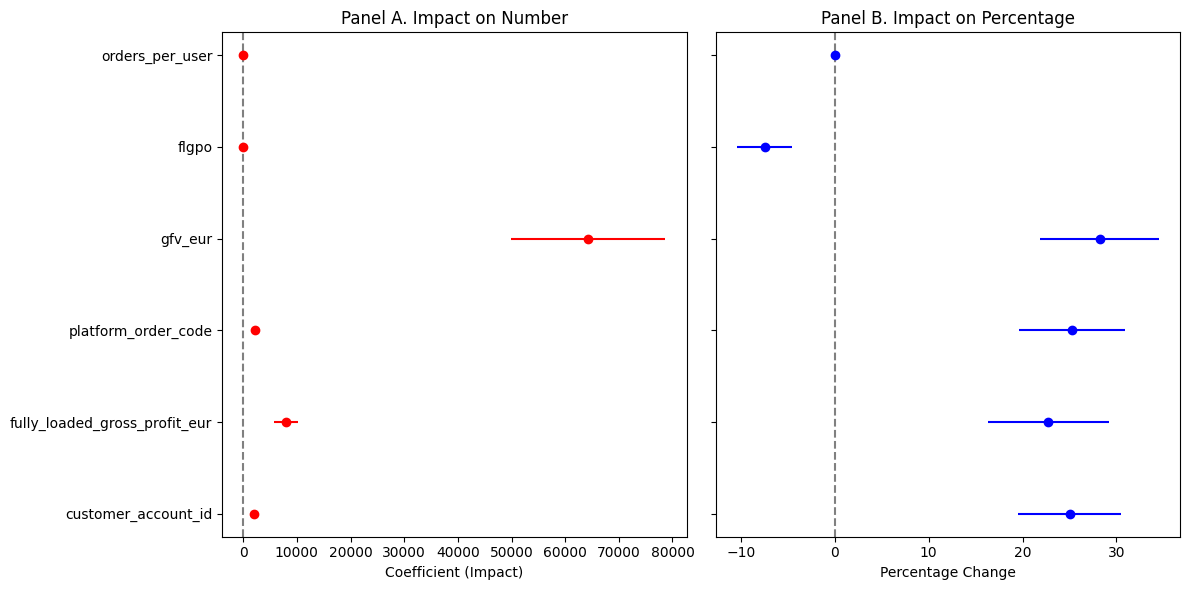

In [532]:
import matplotlib.pyplot as plt


# Creating the chart
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Panel A: Absolute change
axes[0].errorbar(df_results['coef'], df_results['y_var'], 
                 xerr=[df_results['coef'] - df_results['ci_low'], df_results['ci_high'] - df_results['coef']], 
                 fmt='o', color='red', label='Impact on Number')
axes[0].axvline(x=0, color='grey', linestyle='--')
axes[0].set_title('Panel A. Impact on Number')
axes[0].set_xlabel('Coefficient (Impact)')

# Panel B: Percentage change
axes[1].errorbar(df_results['percentage_change'], df_results['y_var'], 
                 xerr=[df_results['percentage_change'] - df_results['ci_low_pct'], 
                       df_results['ci_high_pct'] - df_results['percentage_change']], 
                 fmt='o', color='blue', label='Impact on Percentage')
axes[1].axvline(x=0, color='grey', linestyle='--')
axes[1].set_title('Panel B. Impact on Percentage')
axes[1].set_xlabel('Percentage Change')

# Final touches
plt.tight_layout()
plt.show()


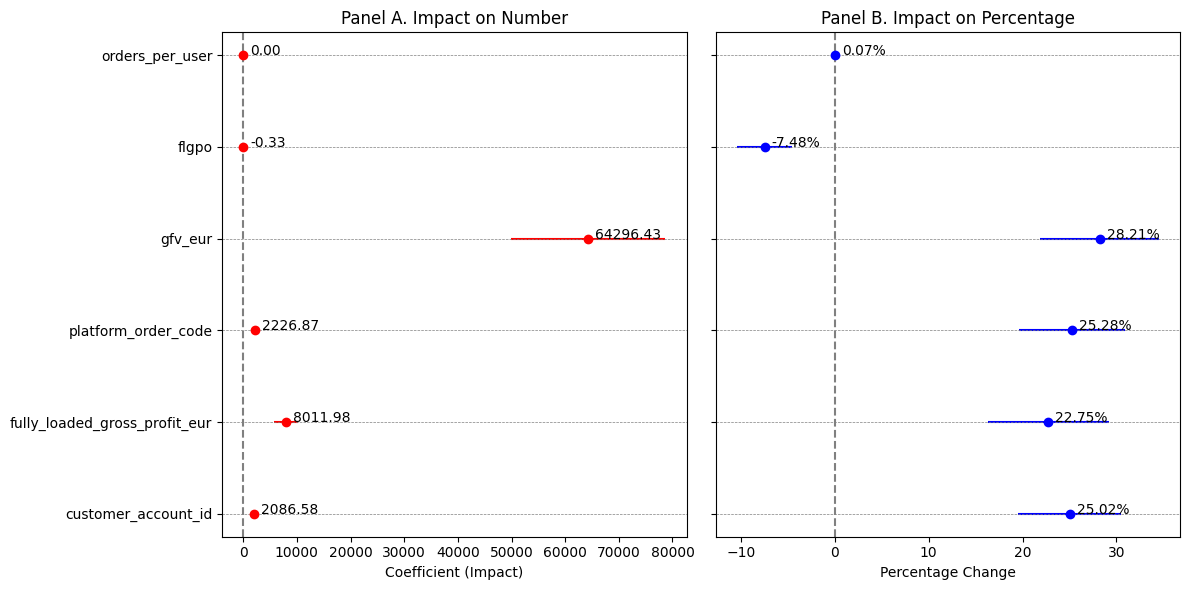

In [524]:
import matplotlib.pyplot as plt

# Creating the chart
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Panel A: Absolute change
axes[0].errorbar(df_results['coef'], df_results['y_var'], 
                 xerr=[df_results['coef'] - df_results['ci_low'], df_results['ci_high'] - df_results['coef']], 
                 fmt='o', color='red', label='Impact on Number')
axes[0].axvline(x=0, color='grey', linestyle='--')
axes[0].set_title('Panel A. Impact on Number')
axes[0].set_xlabel('Coefficient (Impact)')

# Add horizontal dashed lines for each y axis value
for i, y_var in enumerate(df_results['y_var']):
    axes[0].axhline(y=i, color='grey', linestyle='--', linewidth=0.5)

# Panel B: Percentage change
axes[1].errorbar(df_results['percentage_change'], df_results['y_var'], 
                 xerr=[df_results['percentage_change'] - df_results['ci_low_pct'], 
                       df_results['ci_high_pct'] - df_results['percentage_change']], 
                 fmt='o', color='blue', label='Impact on Percentage')
axes[1].axvline(x=0, color='grey', linestyle='--')
axes[1].set_title('Panel B. Impact on Percentage')
axes[1].set_xlabel('Percentage Change')

# Add horizontal dashed lines for each y axis value
for i, y_var in enumerate(df_results['y_var']):
    axes[1].axhline(y=i, color='grey', linestyle='--', linewidth=0.5)

# Adding annotations for coefficients
for i, (coef, y_var) in enumerate(zip(df_results['coef'], df_results['y_var'])):
    axes[0].annotate(f'{coef:.2f}', xy=(coef, i), xytext=(5, 0), textcoords='offset points', color='black')

# Adding annotations for percentage changes
for i, (pct_change, y_var) in enumerate(zip(df_results['percentage_change'], df_results['y_var'])):
    axes[1].annotate(f'{pct_change:.2f}%', xy=(pct_change, i), xytext=(5, 0), textcoords='offset points', color='black')

# Final touches
plt.tight_layout()
plt.show()


In [492]:
from linearmodels.panel import PanelOLS
import pandas as pd
import numpy as np

# Intervention week
intervention_week = '2024-08-06'
intervention_week = pd.to_datetime(intervention_week, format='%Y-%m-%d')

# Aggregating post and pre-treatment for treatment and control groups
a = dps_post_treatment.groupby(['created_date_local']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum','voucher_amount_nc_eur':'sum'}).reset_index()
b = dps_pre_treatment.groupby(['created_date_local']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum','voucher_amount_nc_eur':'sum'}).reset_index()

c = post_control.groupby(['created_date_local']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum','voucher_amount_nc_eur':'sum'}).reset_index()
d = pre_control.groupby(['created_date_local']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum','voucher_amount_nc_eur':'sum'}).reset_index()

# Combine treatment data
frames_t = [a, b]
combined_treatment = pd.concat(frames_t)
combined_treatment['group'] = 'treatment'

# Combine control data
frames_c = [c, d]
combined_control = pd.concat(frames_c)
combined_control['group'] = 'control'

# Combine all data
frames_f = [combined_treatment, combined_control]
final_df = pd.concat(frames_f)

# Convert necessary columns to float
final_df['foregone_delivery_fee'] = final_df['foregone_delivery_fee_final'].astype(float)
final_df['voucher_amount_eur'] = final_df['voucher_amount_nc_eur'].astype(float)

# Add the two columns to get the 'total_cost'
final_df['total_cost'] = final_df['voucher_amount_eur'] + final_df['foregone_delivery_fee']

# Convert 'created_date_local' to datetime
final_df['created_date_local'] = pd.to_datetime(final_df['created_date_local'], errors='coerce')

# Creating flags for treatment, post-intervention
final_df['variant_cities'] = final_df['group'] == 'treatment'
final_df['after'] = final_df['created_date_local'] >= intervention_week
final_df['treated'] = 1 * (final_df['variant_cities'] & final_df['after'])

# Apply log transformation to 'customer_account_id' (log of the dependent variable)
final_df['log_customer_account_id'] = np.log1p(final_df['customer_account_id'])  # Use log1p to handle zero values

# Set 'group' (entity) and 'created_date_local' as a multi-level index for PanelOLS
final_df = final_df.set_index(['group', 'created_date_local'])

# PanelOLS model with the log-transformed dependent variable
model = PanelOLS.from_formula('log_customer_account_id ~ treated + EntityEffects + TimeEffects + total_cost', data=final_df)

# Fitting the model
results = model.fit(cov_type='clustered', cluster_entity=True)

# Display results
print(results)


                             PanelOLS Estimation Summary                             
Dep. Variable:     log_customer_account_id   R-squared:                        0.1841
Estimator:                        PanelOLS   R-squared (Between):              0.0084
No. Observations:                      222   R-squared (Within):               0.0585
Date:                     Sun, Oct 13 2024   R-squared (Overall):              0.0084
Time:                             12:45:47   Log-likelihood                    506.83
Cov. Estimator:                  Clustered                                           
                                             F-statistic:                      12.187
Entities:                                2   P-value                           0.0000
Avg Obs:                            111.00   Distribution:                   F(2,108)
Min Obs:                            111.00                                           
Max Obs:                            111.00   F-statist

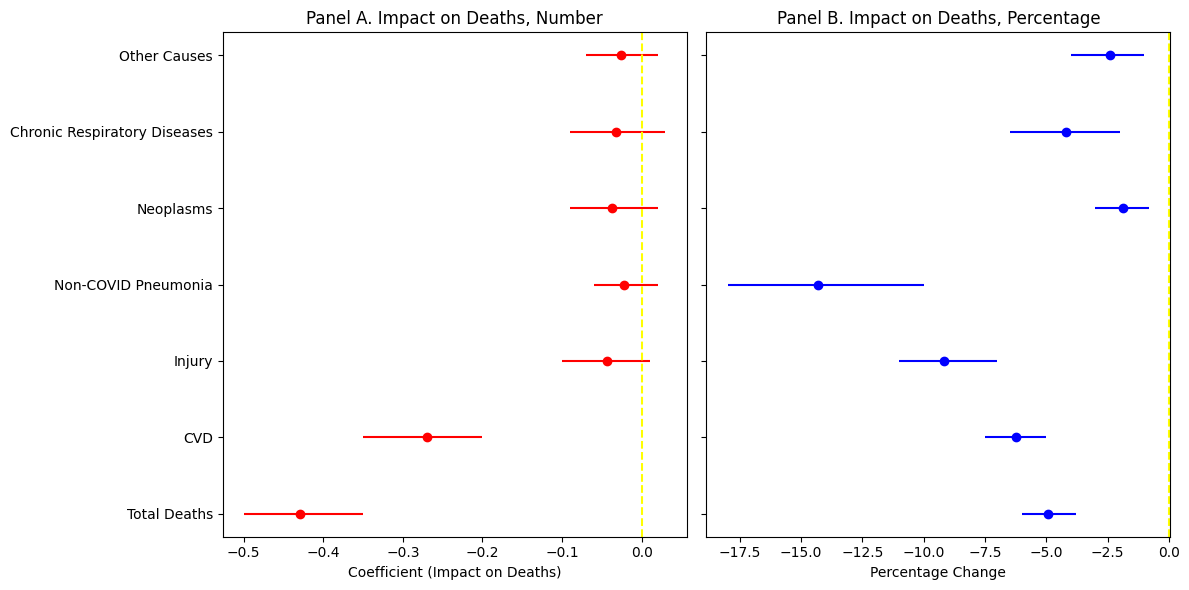

In [495]:
results = {
    'cause': ['Total Deaths', 'CVD', 'Injury', 'Non-COVID Pneumonia', 'Neoplasms', 'Chronic Respiratory Diseases', 'Other Causes'],
    'coef': [-0.429, -0.270, -0.044, -0.022, -0.037, -0.032, -0.026],
    'ci_low': [-0.50, -0.35, -0.10, -0.06, -0.09, -0.09, -0.07],
    'ci_high': [-0.35, -0.20, 0.01, 0.02, 0.02, 0.03, 0.02],
    'percentage_change': [-4.92, -6.23, -9.18, -14.3, -1.88, -4.2, -2.42],
    'ci_low_pct': [-6.0, -7.5, -11.0, -18.0, -3.0, -6.5, -4.0],
    'ci_high_pct': [-3.8, -5.0, -7.0, -10.0, -0.8, -2.0, -1.0]
}

df_results = pd.DataFrame(results)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Panel A: Absolute change in deaths
axes[0].errorbar(df_results['coef'], df_results['cause'], 
                 xerr=[df_results['coef'] - df_results['ci_low'], df_results['ci_high'] - df_results['coef']], 
                 fmt='o', color='red', label='Impact on Deaths (Number)')
axes[0].axvline(x=0, color='yellow', linestyle='--')
axes[0].set_title('Panel A. Impact on Deaths, Number')
axes[0].set_xlabel('Coefficient (Impact on Deaths)')

# Panel B: Percentage change in deaths
axes[1].errorbar(df_results['percentage_change'], df_results['cause'], 
                 xerr=[df_results['percentage_change'] - df_results['ci_low_pct'], 
                       df_results['ci_high_pct'] - df_results['percentage_change']], 
                 fmt='o', color='blue', label='Impact on Deaths (Percentage)')
axes[1].axvline(x=0, color='yellow', linestyle='--')
axes[1].set_title('Panel B. Impact on Deaths, Percentage')
axes[1].set_xlabel('Percentage Change')

# Final touches
plt.tight_layout()
plt.show()



In [493]:
import numpy as np

# Extract the coefficient for the 'treated' variable
treated_coefficient = results.params['treated']

# Calculate the percentage change using the formula
percentage_change = (np.exp(treated_coefficient) - 1) * 100

# Print the result
print(f"Percentage Change due to Treatment: {percentage_change:.2f}%")

Percentage Change due to Treatment: 4.92%


In [491]:
# Step 1: Calculate pre- and post-treatment means for the treatment group
pre_treatment_mean_treatment = final_df[(final_df['variant_cities'] == True) & (final_df['after'] == False)]['customer_account_id'].mean()
post_treatment_mean_treatment = final_df[(final_df['variant_cities'] == True) & (final_df['after'] == True)]['customer_account_id'].mean()

# Step 2: Calculate pre- and post-treatment means for the control group
pre_treatment_mean_control = final_df[(final_df['variant_cities'] == False) & (final_df['after'] == False)]['customer_account_id'].mean()
post_treatment_mean_control = final_df[(final_df['variant_cities'] == False) & (final_df['after'] == True)]['customer_account_id'].mean()

# Step 3: Calculate the percentage change for treatment and control groups
percentage_change_treatment = ((post_treatment_mean_treatment - pre_treatment_mean_treatment) / pre_treatment_mean_treatment) * 100
percentage_change_control = ((post_treatment_mean_control - pre_treatment_mean_control) / pre_treatment_mean_control) * 100

# Step 4: Compute the Difference-in-Differences (DiD) percentage effect
did_percentage_effect = percentage_change_treatment - percentage_change_control

# Step 5: Print the results
print(f"Percentage Change in Treatment Group: {percentage_change_treatment:.2f}%")
print(f"Percentage Change in Control Group: {percentage_change_control:.2f}%")
print(f"Difference-in-Differences (DiD) Percentage Effect: {did_percentage_effect:.2f}%")

# Extracting the coefficient for 'treated' (DiD effect)
treated_effect = results.params['treated']

# Converting the treated effect into a percentage effect based on the baseline mean
baseline_mean_control = pre_treatment_mean_control  # Baseline for control group
treated_percentage_effect = (treated_effect / baseline_mean_control) * 100

print(f"Treated Effect as a Percentage: {treated_percentage_effect:.2f}%")



Percentage Change in Treatment Group: 11.27%
Percentage Change in Control Group: 6.59%
Difference-in-Differences (DiD) Percentage Effect: 4.68%
Treated Effect as a Percentage: 84.16%


In [490]:
# Getting the treated coefficient
treated_coefficient = results.params['treated']

final_df.reset_index(inplace=True)

# Calculate the average value of fully_loaded_gross_profit_eur for the control group
# (In practice, this needs to be calculated from your data. For the sake of this example, assume it's a calculated value)
# Example: 
control_avg_value = final_df.loc[final_df['group'] == 'control', 'fully_loaded_gross_profit_eur'].mean()

# Calculate percentage change
percentage_change = (treated_coefficient / control_avg_value) * 100

# Output the percentage change
percentage_change

15.163472493669031

In [536]:
## Treatment Cities ##

entity_id = 'PO_FI'

city = ('Helsinki','Oulu')
city_str = ",".join([f"'{c}'" for c in city])

## post time period ##
start_date_post = '2024-08-16'
end_date_post = '2024-09-15'
dps_post = client.query(dps_all_f(city_str, entity_id, start_date_post, end_date_post)).to_dataframe()
dps_post['foregone_delivery_fee'] = np.where(
    (dps_post['dps_delivery_fee_eur'] == 0) | (dps_post['dps_delivery_fee_eur'].isnull()), 
    dps_post['dps_standard_fee_eur'], 
    0
)
dps_post['foregone_delivery_fee_final'] = dps_post[(dps_post['has_new_customer_condition'] == False) & (dps_post['new_customer_condition_type'] != 'TOTAL')]['foregone_delivery_fee']


## pre time period ##

# Convert the strings to datetime objects
date_format = "%Y-%m-%d"
start_date = datetime.strptime(start_date_post, date_format)
end_date = datetime.strptime(end_date_post, date_format)

# Calculate the difference in days
days_difference = (end_date - start_date).days
days_difference

# Subtract the number of days from date1
new_date = start_date - timedelta(days=days_difference)
new_date_only = new_date.date()
new_date_string = new_date_only.strftime("%Y-%m-%d")

start_date_pre = new_date_string

tmp_dt_control = datetime.strptime(start_date_post, '%Y-%m-%d')
new_end_d_control = tmp_dt_control - timedelta(days=1)
new_end_d_s_control = new_end_d_control.strftime('%Y-%m-%d')
end_date_pre_control = new_end_d_s_control
end_date_pre = end_date_pre_control


dps_pre = client.query(dps_all_f(city_str, entity_id, start_date_pre, end_date_pre)).to_dataframe()
dps_pre['foregone_delivery_fee'] = np.where(
    (dps_pre['dps_delivery_fee_eur'] == 0) | (dps_pre['dps_delivery_fee_eur'].isnull()), 
    dps_pre['dps_standard_fee_eur'], 
    0
)
dps_pre['foregone_delivery_fee_final'] = dps_pre[(dps_pre['has_new_customer_condition'] == False) & (dps_pre['new_customer_condition_type'] != 'TOTAL')]['foregone_delivery_fee']


cities_summary(dps_pre, dps_post)

entity_id_period,PO_FI_pre,PO_FI_post,percentage_change
Acquistions,62030,61088,-2.0
FDNC_cost_eur,51875,102053,97.0
FLGP_eur,62728,37963,-39.0
GFV_eur,3321059,3251449,-2.0
Orders,128556,130816,2.0
Stacked_orders,3944,11197,184.0
Voucher_cost_eur,159107,209273,32.0
total_acquistion_cost,210982,311326,48.0


In [537]:
## Control Cities ##

entity_id = 'PO_FI'

city = ('Tampere','Turku')
city_str = ",".join([f"'{c}'" for c in city])

## post time period ##
start_date_post = '2024-08-16'
end_date_post = '2024-09-15'
voucher_post_control = client.query(dps_all_f(city_str, entity_id, start_date_post, end_date_post)).to_dataframe()
voucher_post_control['foregone_delivery_fee'] = np.where(
    (voucher_post_control['dps_delivery_fee_eur'] == 0) | (voucher_post_control['dps_delivery_fee_eur'].isnull()), 
    voucher_post_control['dps_standard_fee_eur'], 
    0
)
voucher_post_control['foregone_delivery_fee_final'] = voucher_post_control[(voucher_post_control['has_new_customer_condition'] == False) & (voucher_post_control['new_customer_condition_type'] != 'TOTAL')]['foregone_delivery_fee']


## pre time period ##

# Convert the strings to datetime objects
date_format = "%Y-%m-%d"
start_date = datetime.strptime(start_date_post, date_format)
end_date = datetime.strptime(end_date_post, date_format)

# Calculate the difference in days
days_difference = (end_date - start_date).days
days_difference

# Subtract the number of days from date1
new_date = start_date - timedelta(days=days_difference)
new_date_only = new_date.date()
new_date_string = new_date_only.strftime("%Y-%m-%d")

start_date_pre = new_date_string

tmp_dt_control = datetime.strptime(start_date_post, '%Y-%m-%d')
new_end_d_control = tmp_dt_control - timedelta(days=1)
new_end_d_s_control = new_end_d_control.strftime('%Y-%m-%d')
end_date_pre_control = new_end_d_s_control
end_date_pre = end_date_pre_control

voucher_pre_control = client.query(dps_all_f(city_str, entity_id, start_date_pre, end_date_pre)).to_dataframe()
voucher_pre_control['foregone_delivery_fee'] = np.where(
    (voucher_pre_control['dps_delivery_fee_eur'] == 0) | (voucher_pre_control['dps_delivery_fee_eur'].isnull()), 
    voucher_pre_control['dps_standard_fee_eur'], 
    0
)
voucher_pre_control['foregone_delivery_fee_final'] = voucher_pre_control[(voucher_pre_control['has_new_customer_condition'] == False) & (voucher_pre_control['new_customer_condition_type'] != 'TOTAL')]['foregone_delivery_fee']


cities_summary(voucher_pre_control, voucher_post_control)

entity_id_period,PO_FI_pre,PO_FI_post,percentage_change
Acquistions,29932,33362,11.0
FDNC_cost_eur,35479,53411,51.0
FLGP_eur,87580,68904,-21.0
GFV_eur,1560975,1735436,11.0
Orders,64269,72212,12.0
Stacked_orders,1798,4580,155.0
Voucher_cost_eur,73675,103440,40.0
total_acquistion_cost,109154,156851,44.0


In [538]:
a = dps_post.groupby(['created_date_local']).agg({'customer_account_id':'nunique','platform_order_code':'nunique'}).reset_index()
b = dps_pre.groupby(['created_date_local']).agg({'customer_account_id':'nunique','platform_order_code':'nunique'}).reset_index()

c = voucher_post_control.groupby(['created_date_local']).agg({'customer_account_id':'nunique','platform_order_code':'nunique'}).reset_index()
d = voucher_pre_control.groupby(['created_date_local']).agg({'customer_account_id':'nunique','platform_order_code':'nunique'}).reset_index()

frames_t = [a,b]
combined_treatment  = pd.concat(frames_t)
combined_treatment['group'] = 'treatment'

frames_c = [c,d]
combined_control = pd.concat(frames_c)
combined_control['group'] = 'control'

frames_f = [combined_treatment,combined_control]
final_df = pd.concat(frames_f)

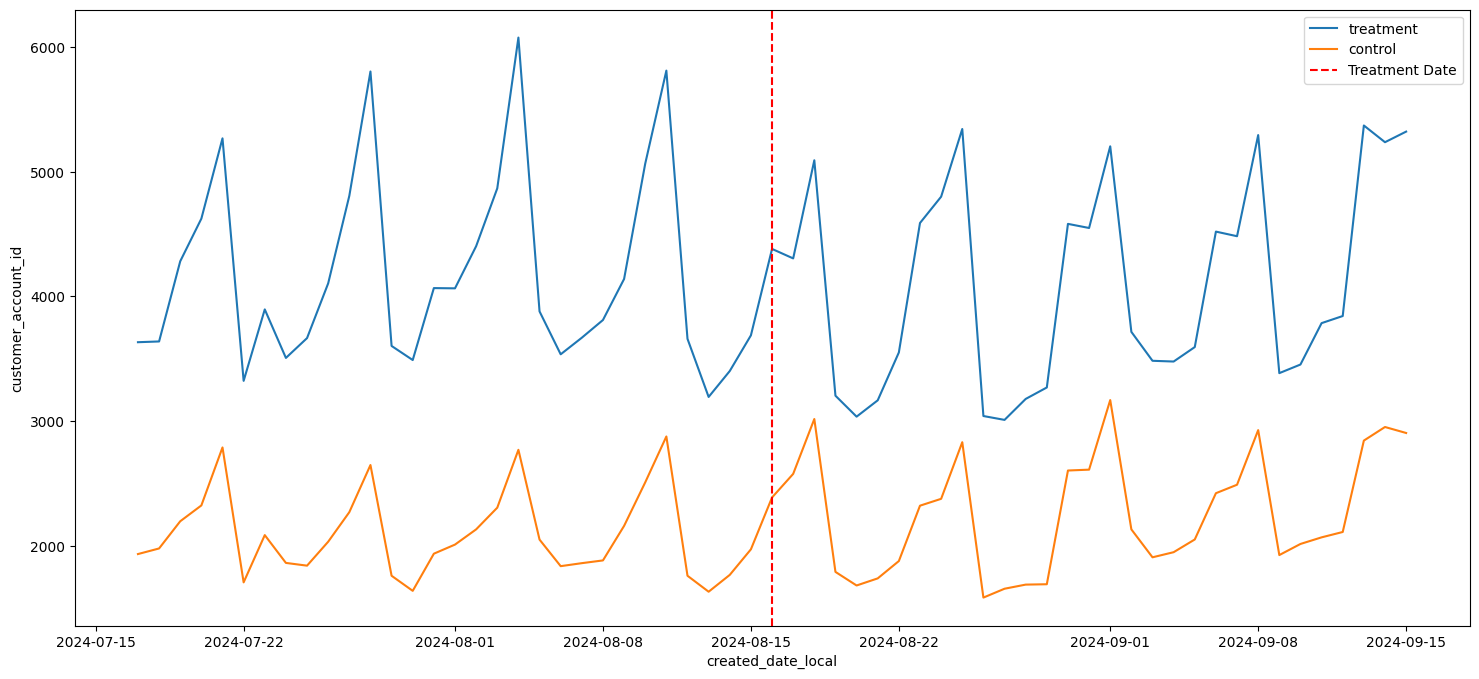

In [539]:
treatment_date = pd.to_datetime('2024-08-16')
plt.figure(figsize=(18, 8))
sns.lineplot(data=final_df, x='created_date_local', y='customer_account_id', hue='group')
plt.axvline(x=treatment_date, color='red', linestyle='--', label='Treatment Date')
plt.legend()
plt.show()

In [540]:
import pandas as pd
import plotly.express as px


# Example intervention date (replace this with your actual intervention date)
intervention_date = '2024-08-16'

# Ensure created_date_local is in datetime format
final_df['created_date_local'] = pd.to_datetime(final_df['created_date_local'], errors='coerce')

# Ensure platform_order_code is numeric
final_df['customer_account_id'] = pd.to_numeric(final_df['customer_account_id'], errors='coerce')
#final_df['log_customer_account_id'] = np.log(final_df_clean['customer_account_id'] + 1)  # Adding 1 to avoid log(0) errors


# Drop rows with missing values in either column
final_df_clean = final_df.dropna(subset=['created_date_local', 'customer_account_id'])

# Separate control and treatment groups
control_group = final_df_clean[final_df_clean['group'] == 'control']
treatment_group = final_df_clean[final_df_clean['group'] == 'treatment']

# Split control group into pre- and post-intervention
control_pre = control_group[control_group['created_date_local'] < intervention_date]
control_post = control_group[control_group['created_date_local'] >= intervention_date]

# Split treatment group into pre- and post-intervention
treatment_pre = treatment_group[treatment_group['created_date_local'] < intervention_date]
treatment_post = treatment_group[treatment_group['created_date_local'] >= intervention_date]

# Scatter plot for the control group (pre-intervention) with regression line and confidence intervals
fig = px.scatter(
    control_pre,
    x='created_date_local',
    y='customer_account_id',
    color_discrete_sequence=['blue'],  # Pre-intervention control in blue
    trendline='ols',  # Regression line for pre-intervention control
    trendline_scope='trace',  # Ensures confidence intervals are plotted
    trendline_color_override='blue'
)

# Add confidence intervals for the pre-intervention control group
fig.add_trace(
    px.scatter(
        control_pre,
        x='created_date_local',
        y='customer_account_id',
        color_discrete_sequence=['blue'],
        trendline='ols',  # Regression line for pre-intervention control
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='blue'
    ).data[1]  # Selecting only the trendline trace
)

# Scatter plot for the control group (post-intervention) with regression line and confidence intervals
fig.add_trace(
    px.scatter(
        control_post,
        x='created_date_local',
        y='customer_account_id',
        color_discrete_sequence=['lightblue'],  # Post-intervention control in light blue
        trendline='ols',  # Regression line for post-intervention control
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='lightblue'
    ).data[0]  # Selecting only the scatter trace
)

fig.add_trace(
    px.scatter(
        control_post,
        x='created_date_local',
        y='customer_account_id',
        color_discrete_sequence=['lightblue'],
        trendline='ols',  # Regression line for post-intervention control
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='lightblue'
    ).data[1]  # Selecting only the trendline trace
)

# Scatter plot for the treatment group (pre-intervention) with regression line and confidence intervals
fig.add_trace(
    px.scatter(
        treatment_pre,
        x='created_date_local',
        y='customer_account_id',
        color_discrete_sequence=['green'],  # Pre-intervention treatment in green
        trendline='ols',  # Regression line for pre-intervention treatment
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='green'
    ).data[0]  # Selecting only the scatter trace
)

fig.add_trace(
    px.scatter(
        treatment_pre,
        x='created_date_local',
        y='customer_account_id',
        color_discrete_sequence=['green'],
        trendline='ols',  # Regression line for pre-intervention treatment
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='green'
    ).data[1]  # Selecting only the trendline trace
)

# Scatter plot for the treatment group (post-intervention) with regression line and confidence intervals
fig.add_trace(
    px.scatter(
        treatment_post,
        x='created_date_local',
        y='customer_account_id',
        color_discrete_sequence=['red'],  # Post-intervention treatment in red
        trendline='ols',  # Regression line for post-intervention treatment
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='red'
    ).data[0]  # Selecting only the scatter trace
)

fig.add_trace(
    px.scatter(
        treatment_post,
        x='created_date_local',
        y='customer_account_id',
        color_discrete_sequence=['red'],
        trendline='ols',  # Regression line for post-intervention treatment
        trendline_scope='trace',  # Ensures confidence intervals are plotted
        trendline_color_override='red'
    ).data[1]  # Selecting only the trendline trace
)

# Update layout for better visualization
fig.update_layout(
    xaxis_title='created_date_local',
    yaxis_title='Log Customer Account ID',
    yaxis_range=[0, None],  # Start y-axis at 0
    legend_title='Group',
    height=600,  # Height of the plot
    width=1200,  # Width of the plot
    showlegend=False  # Hide duplicate legends from added traces
)

# Show the plot
fig.show()

In [546]:
final_df['total_cost']

group      created_date_local
treatment  2024-08-16            7461.99
           2024-08-17            7787.52
           2024-08-18            8203.17
           2024-08-19            5977.86
           2024-08-20            5694.43
                                  ...   
control    2024-09-11            6394.78
           2024-09-12            6195.25
           2024-09-13            8458.41
           2024-09-14            9241.36
           2024-09-15            8798.64
Name: total_cost, Length: 123, dtype: float64

In [548]:
from linearmodels.panel import PanelOLS
import pandas as pd

# Intervention week
intervention_week = '2024-08-12'
intervention_week = pd.to_datetime(intervention_week, format='%Y-%m-%d')

# Aggregating post and pre-treatment for treatment and control groups
a = dps_post.groupby(['created_date_local']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum','voucher_amount_nc_eur':'sum'}).reset_index()
b = dps_pre.groupby(['created_date_local']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum','voucher_amount_nc_eur':'sum'}).reset_index()

c = voucher_post_control.groupby(['created_date_local']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum','voucher_amount_nc_eur':'sum'}).reset_index()
d = voucher_post_control.groupby(['created_date_local']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum','voucher_amount_nc_eur':'sum'}).reset_index()

# Combine treatment data
frames_t = [a, b]
combined_treatment = pd.concat(frames_t)
combined_treatment['group'] = 'treatment'

# Combine control data
frames_c = [c, d]
combined_control = pd.concat(frames_c)
combined_control['group'] = 'control'

# Combine all data
frames_f = [combined_treatment, combined_control]
final_df = pd.concat(frames_f)

# Convert necessary columns to float
final_df['foregone_delivery_fee'] = final_df['foregone_delivery_fee_final'].astype(float)
final_df['voucher_amount_eur'] = final_df['voucher_amount_nc_eur'].astype(float)

# Add the two columns to get the 'total_cost'
final_df['total_cost'] = final_df['voucher_amount_eur'] + final_df['foregone_delivery_fee']

# Convert week to datetime
final_df['created_date_local'] = pd.to_datetime(final_df['created_date_local'], errors='coerce')

# Creating flags for treatment, post-intervention
final_df['variant_cities'] = final_df['group'] == 'treatment'
final_df['after'] = final_df['created_date_local'] >= intervention_week
final_df['treated'] = 1 * (final_df['variant_cities'] & final_df['after'])

# Set 'group' (entity) and 'week' as a multi-level index for PanelOLS
final_df = final_df.set_index(['group', 'created_date_local'])

# PanelOLS model, using the formula for difference-in-differences
model = PanelOLS.from_formula('customer_account_id ~ treated + EntityEffects + TimeEffects', data=final_df)

# Fitting the model
results = model.fit(cov_type='clustered', cluster_entity=False)

# Display results
print(results)


                           PanelOLS Estimation Summary                           
Dep. Variable:     customer_account_id   R-squared:                     -2.22e-16
Estimator:                    PanelOLS   R-squared (Between):             -0.4817
No. Observations:                  123   R-squared (Within):              -0.8605
Date:                 Sun, Oct 13 2024   R-squared (Overall):             -0.4939
Time:                         15:59:36   Log-likelihood                   -793.64
Cov. Estimator:              Clustered                                           
                                         F-statistic:                  -9.647e-15
Entities:                            2   P-value                           1.0000
Avg Obs:                        61.500   Distribution:                    F(1,60)
Min Obs:                        61.000                                           
Max Obs:                        62.000   F-statistic (robust):          2.356e-29
                

In [479]:
final_df

fully_loaded_gross_profit_eur  platform_order_code  \
group     week                                                             
treatment 2024-08-12                   25841.700526                28460   
          2024-08-19                   26581.889515                28427   
          2024-08-26                   14039.139617                27576   
          2024-09-02                      64.012926                29286   
          2024-09-09                  -12089.007018                31269   
          2024-07-08                    1839.622381                25743   
          2024-07-15                    1673.534961                29338   
          2024-07-22                    9228.032126                29942   
          2024-07-29                   15478.426410                31480   
          2024-08-05                   23532.068246                30787   
control   2024-08-12                   23337.487368                15510   
          2024-08-19                   22198.591404                15022   
          2024-08-26                   19493.888596                15438   
          2024-09-02                   11687.617368                16274   
          2024-09-09                    2559.280175                17265   
          2024-08-12                   23337.487368                15510   
          2024-08-19                   22198.591404                15022   
          2024-08-26                   19493.888596                15438   
          2024-09-02                   11687.617368                16274   
          2024-09-09                    2559.280175                17265   

                      customer_account_id  voucher_amount_eur  \
group     week                                                  
treatment 2024-08-12                21464            35257.53   
          2024-08-19                21429            34868.88   
          2024-08-26                20929            44351.05   
          2024-09-02                22056            53876.09   
          2024-09-09                23508            58482.07   
          2024-07-08                20066            31342.99   
          2024-07-15                22190            40434.60   
          2024-07-22                22821            40997.48   
          2024-07-29                23406            33481.65   
          2024-08-05                22962            35454.25   
control   2024-08-12                11639            16821.09   
          2024-08-19                11201            16188.28   
          2024-08-26                11634            20988.61   
          2024-09-02                12094            26995.23   
          2024-09-09                12967            30216.07   
          2024-08-12                11639            16821.09   
          2024-08-19                11201            16188.28   
          2024-08-26                11634            20988.61   
          2024-09-02                12094            26995.23   
          2024-09-09                12967            30216.07   

                     foregone_delivery_fee_final  voucher_amount_nc_eur  \
group     week                                                            
treatment 2024-08-12             12240.190000000               35257.53   
          2024-08-19             13850.720000000               34868.88   
          2024-08-26             13402.260000000               44351.05   
          2024-09-02             15739.350000000               53876.09   
          2024-09-09             35889.510000000               58482.07   
          2024-07-08             10434.590000000               31342.99   
          2024-07-15             12013.420000000               40434.60   
          2024-07-22             11851.130000000               40997.48   
          2024-07-29             12157.780000000               33481.65   
          2024-08-05             11875.660000000               35454.25   
control   2024-08-

In [ ]:
# from linearmodels.panel import PanelOLS
# import pandas as pd

# intervention_week = '2024-08-06'
# intervention_week = pd.to_datetime(intervention_week, format='%Y-%m-%d')

# a = dps_post_treatment.groupby(['city_name','week']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum'}).reset_index()
# b = dps_pre_treatment.groupby(['city_name','week']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum'}).reset_index()

# c = post_control.groupby(['city_name','week']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum'}).reset_index()
# d = pre_control.groupby(['city_name','week']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum'}).reset_index()

# frames_t = [a,b]
# combined_treatment  = pd.concat(frames_t)
# combined_treatment['group'] = 'treatment'

# frames_c = [c,d]
# combined_control = pd.concat(frames_c)
# combined_control['group'] = 'control'

# frames_f = [combined_treatment,combined_control]
# final_df = pd.concat(frames_f)

# # Convert the columns to float
# final_df['foregone_delivery_fee_final'] = final_df['foregone_delivery_fee'].astype(float)
# final_df['voucher_amount_eur'] = final_df['voucher_amount_eur'].astype(float)

# # Add the two columns to get the 'total_cost'
# final_df['total_cost'] = final_df['voucher_amount_eur'] + final_df['foregone_delivery_fee_final']

# final_df['week'] = pd.to_datetime(final_df['week'], errors='coerce')
# final_df['variant_cities'] = final_df['group'].isin(['treatment'])
# final_df['after'] = final_df['week'] >= intervention_week
# final_df['treated'] = 1*(final_df['variant_cities'] & final_df['after'])

# final_df.set_index(['city_name', 'week'], inplace=True)

# model = PanelOLS.from_formula('fully_loaded_gross_profit_eur ~ treated + EntityEffects + TimeEffects + voucher_amount_eur', data=final_df)
# results = model.fit(cov_type='clustered', cluster_entity=True)

# results

In [ ]:
# from linearmodels.panel import PanelOLS
# import pandas as pd

# # Intervention week
# intervention_week = '2024-08-05'
# intervention_week = pd.to_datetime(intervention_week, format='%Y-%m-%d')

# # Aggregating post and pre-treatment for treatment and control groups
# a = dps_post_treatment.groupby(['week']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum'}).reset_index()
# b = dps_pre_treatment.groupby(['week']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum'}).reset_index()

# c = post_control.groupby(['week']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum'}).reset_index()
# d = pre_control.groupby(['week']).agg({'fully_loaded_gross_profit_eur':'sum','platform_order_code':'nunique','customer_account_id':'nunique','foregone_delivery_fee':'sum','voucher_amount_eur':'sum','foregone_delivery_fee_final':'sum'}).reset_index()

# # Combine treatment data
# frames_t = [a, b]
# combined_treatment = pd.concat(frames_t)
# combined_treatment['group'] = 'treatment'

# # Combine control data
# frames_c = [c, d]
# combined_control = pd.concat(frames_c)
# combined_control['group'] = 'control'

# # Combine all data
# frames_f = [combined_treatment, combined_control]
# final_df = pd.concat(frames_f)

# # Convert necessary columns to float
# final_df['foregone_delivery_fee'] = final_df['foregone_delivery_fee'].astype(float)
# final_df['voucher_amount_eur'] = final_df['voucher_amount_eur'].astype(float)

# # Add the two columns to get the 'total_cost'
# final_df['total_cost'] = final_df['voucher_amount_eur'] + final_df['foregone_delivery_fee']

# # Convert week to datetime
# final_df['week'] = pd.to_datetime(final_df['week'], errors='coerce')

# # Creating flags for treatment, post-intervention
# final_df['variant_cities'] = final_df['group'] == 'treatment'
# final_df['after'] = final_df['week'] >= intervention_week
# final_df['treated'] = 1 * (final_df['variant_cities'] & final_df['after'])

# # Set 'group' (entity) and 'week' as a multi-level index for PanelOLS
# final_df = final_df.set_index(['group', 'week'])

# # PanelOLS model, using the formula for difference-in-differences
# model = PanelOLS.from_formula('fully_loaded_gross_profit_eur ~ treated + EntityEffects + TimeEffects+ total_cost', data=final_df)

# # Fitting the model
# results = model.fit(cov_type='clustered', cluster_entity=True)

# # Display results
# print(results)


In [435]:
# # Getting the treated coefficient
# treated_coefficient = results.params['treated']

# final_df.reset_index(inplace=True)

# # Calculate the average value of fully_loaded_gross_profit_eur for the control group
# # (In practice, this needs to be calculated from your data. For the sake of this example, assume it's a calculated value)
# # Example: 
# control_avg_value = final_df.loc[final_df['group'] == 'control', 'fully_loaded_gross_profit_eur'].mean()

# # Calculate percentage change
# percentage_change = (treated_coefficient / control_avg_value) * 100

# # Output the percentage change
# percentage_change

38.43648648270954

In [436]:
final_df['total_cost'].sum()

2851718.272230131

In [437]:
36000 / 2851718.272230131

0.012623967925080797

In [438]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# Convert the 'week' column to numeric format (e.g., ordinal or integer representing week)
# control_pre['week_numeric'] = control_pre['week'].apply(lambda x: x.toordinal())
# control_post['week_numeric'] = control_post['week'].apply(lambda x: x.toordinal())
# treatment_pre['week_numeric'] = treatment_pre['week'].apply(lambda x: x.toordinal())
# treatment_post['week_numeric'] = treatment_post['week'].apply(lambda x: x.toordinal())


# # Create a figure with subplots to display all the groups
# plt.figure(figsize=(12, 8))

# # Scatter plot with regression line and confidence intervals for control group pre-intervention
# sns.regplot(
#     x='week_numeric',
#     y='customer_account_id',
#     data=control_pre,
#     scatter_kws={'color': 'blue'},  # Blue for control pre-intervention
#     line_kws={'color': 'blue'},
#     ci=95,  # 95% confidence interval
#     label='Control Pre'
# )

# # Scatter plot with regression line and confidence intervals for control group post-intervention
# sns.regplot(
#     x='week_numeric',
#     y='customer_account_id',
#     data=control_post,
#     scatter_kws={'color': 'lightblue'},  # Light blue for control post-intervention
#     line_kws={'color': 'lightblue'},
#     ci=95,  # 95% confidence interval
#     label='Control Post'
# )

# # Scatter plot with regression line and confidence intervals for treatment group pre-intervention
# sns.regplot(
#     x='week_numeric',
#     y='customer_account_id',
#     data=treatment_pre,
#     scatter_kws={'color': 'green'},  # Green for treatment pre-intervention
#     line_kws={'color': 'green'},
#     ci=95,  # 95% confidence interval
#     label='Treatment Pre'
# )

# # Scatter plot with regression line and confidence intervals for treatment group post-intervention
# sns.regplot(
#     x='week_numeric',
#     y='customer_account_id',
#     data=treatment_post,
#     scatter_kws={'color': 'red'},  # Red for treatment post-intervention
#     line_kws={'color': 'red'},
#     ci=95,  # 95% confidence interval
#     label='Treatment Post'
# )

# # Add labels and a legend
# plt.xlabel('Week (Ordinal)')
# plt.ylabel('Customer Account ID')
# plt.title('Regression Plots with Confidence Intervals for Control and Treatment Groups')
# plt.legend()

# # Show the plot
# plt.show()
